In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from shapely import Point, LineString
import opentnsim.model as model
import opentnsim.vessel as vessel_module
import datetime
import random
import ortools
import matplotlib.pyplot as plt
import math
from ortools.sat.python import cp_model

In [2]:
def rotate(p, origin=(0, 0), degrees=0):
    angle = -np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

def vessel_shape(length,width,x_offset=0,y_offset=0,direction=0):
    x_coords = [-0.5*width,0,0.5*width, 0.5*width, -0.5*width]
    y_coords = [length/2-width,length/2,length/2 - width,-length/2, -length/2]
    polygon = rotate([(x,y) for x,y in zip(x_coords,y_coords)],degrees=direction)
    for i,(x,y) in enumerate(polygon):
        x_coords[i] = x
        y_coords[i] = y
    x_coords = [x + x_offset for x in x_coords]
    y_coords = [y + y_offset for y in y_coords]
    return x_coords, y_coords

In [3]:
graph = nx.MultiDiGraph()
graph.add_node('0', geometry=Point(0,0))
graph.add_node('1', geometry=Point(0,1))
graph.add_edge('0','1',geometry=LineString([Point(0,0),Point(0,1)]))
graph = graph.to_undirected()
graph = graph.to_directed()
simulation_start = datetime.datetime.now()
simulation_stop = datetime.datetime.now()

In [4]:
sim = model.Simulation(graph=graph,simulation_start=simulation_start,simulation_stop=simulation_stop)
env = sim.environment

return code:4
status:OPTIMAL


,bin,x,y,w,l,t
0,0,0.0,0.0,46.0,374.0,2025-01-07 19:01:27.120
1,1,0.0,0.0,35.0,286.0,2025-01-07 20:14:31.590
2,1,40.0,0.0,30.0,240.0,2025-01-07 18:25:30.410
3,1,41.0,240.0,29.0,233.0,2025-01-07 20:21:20.740
4,0,51.0,0.0,19.0,159.0,2025-01-07 19:48:43.920


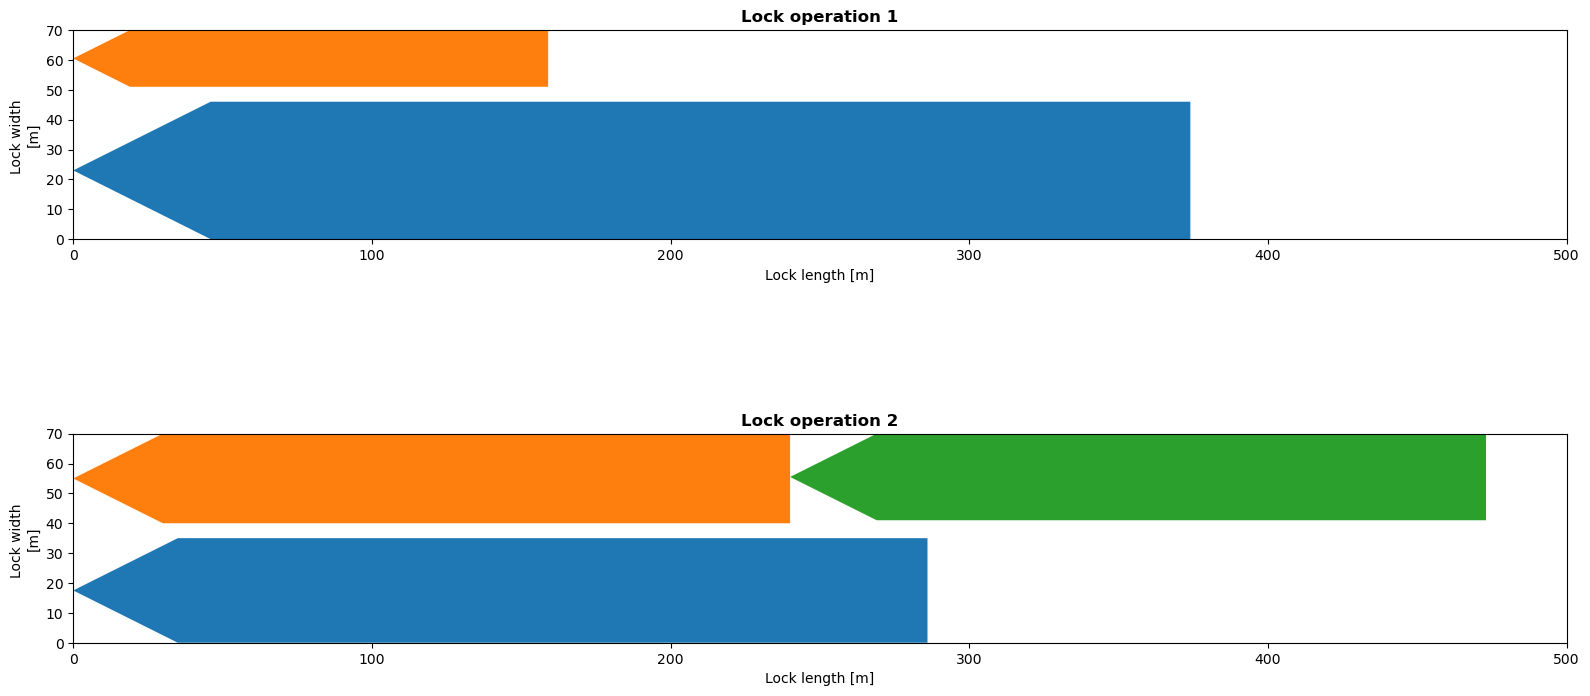

In [5]:
vessel_queue = pd.DataFrame(columns = ['vessel_id','t_arrival','L','B','T','type','bound'])
earlier_delay = 0
vessels = []
for vessel_index in range(5):
    random_width = random.uniform(10,50)
    random_delay = random.uniform(0,60)+earlier_delay
    vessel = vessel_module.IsVessel(name='test',env=env,origin='0',destination='1',type='test',B=np.floor(random_width),L=np.floor(8*random_width),T=np.floor(random_width/8),arrival_time=simulation_start+datetime.timedelta(minutes=random_delay),bound='inbound')
    earlier_delay += random_delay-earlier_delay
    vessels.append(vessel)
for i,vessel in enumerate(vessels):
    vessel_queue.loc[i,:] = [vessel.id,vessel.metadata['arrival_time'],vessel.L,vessel.B,vessel.T,vessel.type,vessel.bound]

vessel_queue = vessel_queue.sort_values('L',ascending=False)

model = cp_model.CpModel()

max_safety_length = 20
max_safety_width = 10

lock_dimensions = (500,70)
lock_dimensions = [dimension*10 for dimension in lock_dimensions]
lock_L = lock_dimensions[0]
lock_B = lock_dimensions[1]

vessel_lengths = []
vessel_widths = []
vessel_arrival_times = []
for _,vessel in vessel_queue.iterrows():
    vessel_lengths.append(int(vessel['L']*10))
    vessel_widths.append(int(vessel['B'])*10)
    vessel_arrival_times.append(int(vessel['t_arrival'].timestamp()*100))
number_of_vessels = len(vessel_queue)
number_of_locks = 10

# X and Y
x = [model.NewIntVar(0,lock_B-vessel_widths[i],f'x{i}') for i in range(number_of_vessels)]

xb1 = [model.NewIntVar(0,number_of_locks*lock_B-vessel_widths[i],f'xb1.{i}') for i in range(number_of_vessels)]
xb2 = [model.NewIntVar(lock_B-vessel_widths[i],number_of_locks*lock_B,f'xb2.{i}') for i in range(number_of_vessels)]

y1 = [model.NewIntVar(0,lock_L-vessel_lengths[i],f'y1.{i}') for i in range(number_of_vessels)]
y2 = [model.NewIntVar(vessel_lengths[i],lock_L,f'y2.{i}') for i in range(number_of_vessels)]

# Interval variables
xival = [model.NewIntervalVar(xb1[i],vessel_widths[i],xb2[i],f'xival{i}') for i in range(number_of_vessels)]
yival = [model.NewIntervalVar(y1[i],vessel_lengths[i],y2[i],f'yival{i}') for i in range(number_of_vessels)]

# Bin numbers
b = [model.NewIntVar(0,number_of_locks-1,f'b{i}') for i in range(number_of_vessels)]

for i in range(number_of_vessels):
    model.Add(xb1[i] == x[i] + b[i]*lock_B)
    model.Add(xb2[i] == xb1[i] + vessel_widths[i])
    model.AddLinearExpressionInDomain(x[i]+vessel_widths[i], cp_model.Domain.FromValues([vessel_widths[i], lock_B]))
    
# objective
lock_operations = model.NewIntVar(0,number_of_locks-1,'lock_operations')

# Enforce that no two rectangles overlap
model.AddNoOverlap2D(xival, yival)
model.AddMaxEquality(lock_operations,[b[i] for i in range(number_of_vessels)])

# objective
model.Minimize(lock_operations)  

# Solve model
solver = cp_model.CpSolver()
rc = solver.solve(model)
print(f"return code:{rc}")
print(f"status:{solver.StatusName()}")

# Output
vessel_planning = pd.DataFrame({'bin' : [solver.Value(b[i]) for i in range(number_of_vessels)],
                                'x'   : [solver.Value(x[i])/10 for i in range(number_of_vessels)],
                                'y'   : [solver.Value(y1[i])/10 for i in range(number_of_vessels)],
                                'w'   : [width/10 for width in vessel_widths],
                                'l'   : [length/10 for length in vessel_lengths],
                                't'   : [datetime.datetime.fromtimestamp(time/100) for time in vessel_arrival_times]})

number_of_lock_operations = int(vessel_planning['bin'].max()+1)
lock_dimensions = [dimension/10 for dimension in lock_dimensions]
fig,axes = plt.subplots(number_of_lock_operations,1,figsize=(16,9))
for lock_operation_nr in range(number_of_lock_operations):
    if number_of_lock_operations > 1:
        ax = axes[lock_operation_nr]
    else:
        ax = axes
    ax.set_xlim(0,lock_dimensions[0])
    ax.set_ylim(0,lock_dimensions[1])
    for _,v in vessel_planning[vessel_planning.bin == lock_operation_nr].iterrows():
        x_loc = v['y']+v['l']/2
        y_loc = v['x']+v['w']/2
        x_coords, y_coords = vessel_shape(v['l'],v['w'],x_loc,y_loc,direction=-90)
        ax.fill(x_coords, y_coords)
    ax.set_title(f'Lock operation {lock_operation_nr+1}',weight='bold')
    ax.set_xlabel('Lock length [m]')
    ax.set_ylabel('Lock width \n[m]')
    ax.set_aspect('equal')
plt.tight_layout()

vessel_planning

In [6]:
vessel_queue = pd.DataFrame(columns = ['vessel_id','t_arrival','L','B','T','type','bound'])
earlier_delay = 0
vessels = []
for vessel_index in range(20):
    random_length = random.uniform(150,300)
    random_delay = random.uniform(0,60)+earlier_delay
    vessel = vessel_module.IsVessel(name='test',env=env,origin='0',destination='1',type='test',B=np.floor(random_length/7.5),L=np.floor(random_length),T=np.floor(random_length/25),arrival_time=simulation_start+datetime.timedelta(minutes=random_delay),bound='inbound')
    earlier_delay += random_delay-earlier_delay
    vessels.append(vessel)
for i,vessel in enumerate(vessels):
    vessel_queue.loc[i,:] = [vessel.id,vessel.metadata['arrival_time'],vessel.L,vessel.B,vessel.T,vessel.type,vessel.bound]

vessel_queue = vessel_queue.sort_values('t_arrival')
vessel_queue = vessel_queue.sort_values('L',ascending=False)

return code:4
status:OPTIMAL


,lock_operation,x_left_loc,y_top_loc,B,L
0,0,0,0.0,37.0,279.0
1,1,0,0.0,36.0,275.0
2,2,0,0.0,35.0,266.0
3,3,0,0.0,35.0,262.0
4,4,0,0.0,34.0,262.0
5,5,0,0.0,33.0,253.0
6,5,0,253.0,32.0,247.0
7,6,0,0.0,32.0,240.0
8,3,0,262.0,31.0,238.0
9,0,0,279.0,28.0,216.0


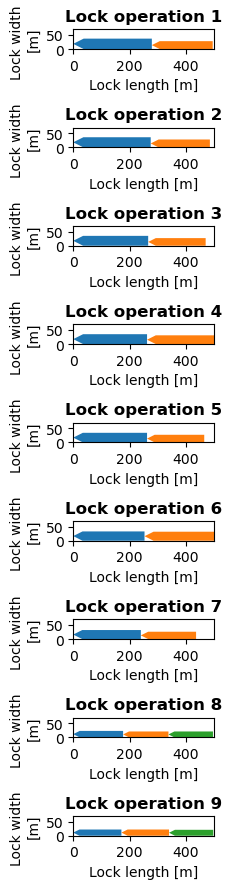

In [7]:
def lock_planning_model(vessel_queue, lock_dimensions, max_safety_length = 0, number_of_locks = 10):
    model = cp_model.CpModel()
    max_safety_length = max_safety_length*10
    lock_dimensions = [dimension*10 for dimension in lock_dimensions]
    lock_L = int(lock_dimensions[0])
    lock_B = int(lock_dimensions[1])

    vessel_lengths = []
    vessel_widths = []
    vessel_arrival_times = []
    for _,vessel in vessel_queue.iterrows():
        vessel_lengths.append(int(vessel['L']*10)+max_safety_length)
        vessel_widths.append(int(vessel['B'])*10)
    number_of_vessels = len(vessel_queue)

    # X and Y
    y = [model.NewIntVar(max_safety_length,lock_L-vessel_lengths[i]-max_safety_length,f'x{i}') for i in range(number_of_vessels)]
    
    y1 = [model.NewIntVar(0,number_of_locks*lock_L-vessel_lengths[i],f'y1.{i}') for i in range(number_of_vessels)]
    y2 = [model.NewIntVar(lock_L-vessel_lengths[i],number_of_locks*lock_L,f'y2.{i}') for i in range(number_of_vessels)]
    
    # Interval variables
    yival = [model.NewIntervalVar(y1[i],vessel_lengths[i],y2[i],f'yival{i}') for i in range(number_of_vessels)]
    
    # Bin numbers
    b = [model.NewIntVar(0,number_of_locks-1,f'b{i}') for i in range(number_of_vessels)]
    
    for i in range(number_of_vessels):
        model.Add(y1[i] == y[i] + b[i]*lock_L)
        model.Add(y2[i] == y1[i] + vessel_lengths[i])
        
    # objective
    lock_operations = model.NewIntVar(0,number_of_locks-1,'lock_operations')
    
    # Enforce that no two rectangles overlap
    model.AddNoOverlap(yival)
    model.AddMaxEquality(lock_operations,[b[i] for i in range(number_of_vessels)])
    
    # objective
    model.Minimize(lock_operations)  
    
    # Solve model
    solver = cp_model.CpSolver()
    rc = solver.solve(model)
    print(f"return code:{rc}")
    print(f"status:{solver.StatusName()}")
    
    # Output
    vessel_planning = pd.DataFrame({'lock_operation' : [solver.Value(b[i]) for i in range(number_of_vessels)],
                                    'x_left_loc'   : [0 for width in vessel_widths],
                                    'y_top_loc'   : [solver.Value(y[i])/10 for i in range(number_of_vessels)],
                                    'B'   : [width/10 for width in vessel_widths],
                                    'L'   : [length/10-max_safety_length/10 for length in vessel_lengths]})
    return vessel_planning

lock_dimensions = (500,70)
max_safety_length = 0
max_safety_width = 0
vessel_planning = lock_planning_model(vessel_queue = vessel_queue, lock_dimensions = lock_dimensions, max_safety_length = max_safety_length)
number_of_lock_operations = int(vessel_planning['lock_operation'].max()+1)
fig,axes = plt.subplots(number_of_lock_operations,1,figsize=(16,9))
for lock_operation_nr in range(number_of_lock_operations):
    if number_of_lock_operations > 1:
        ax = axes[lock_operation_nr]
    else:
        ax = axes
    ax.set_xlim(0,lock_dimensions[0])
    ax.set_ylim(0,lock_dimensions[1])
    for _,v in vessel_planning[vessel_planning.lock_operation == lock_operation_nr].iterrows():
        x_loc = v['y_top_loc']+v['L']/2
        y_loc = v['x_left_loc']+v['B']/2
        x_coords, y_coords = vessel_shape(v['L'],v['B'],x_loc,y_loc,direction=-90)
        ax.fill(x_coords, y_coords)
    ax.set_title(f'Lock operation {lock_operation_nr+1}',weight='bold')
    ax.set_xlabel('Lock length [m]')
    ax.set_ylabel('Lock width \n[m]')
    ax.set_aspect('equal')
plt.tight_layout()
vessel_planning

return code:4
status:OPTIMAL
    lock_operation  x_left_loc  y_top_loc     B      L
0                0           0       10.0  37.0  279.0
1                1           0       10.0  36.0  275.0
2                2           0       10.0  35.0  266.0
3                3           0       10.0  35.0  262.0
4                4           0       10.0  34.0  262.0
5                5           0       10.0  33.0  253.0
6                6           0       10.0  32.0  247.0
7                7           0       10.0  32.0  240.0
8                8           0       10.0  31.0  238.0
9                7           0      260.0  28.0  216.0
10               6           0      267.0  28.0  210.0
11               5           0      273.0  27.0  204.0
12               8           0      258.0  27.0  203.0
13               3           0      282.0  26.0  196.0
14               0           0      299.0  23.0  177.0
15               1           0      295.0  22.0  171.0
16               2           0      

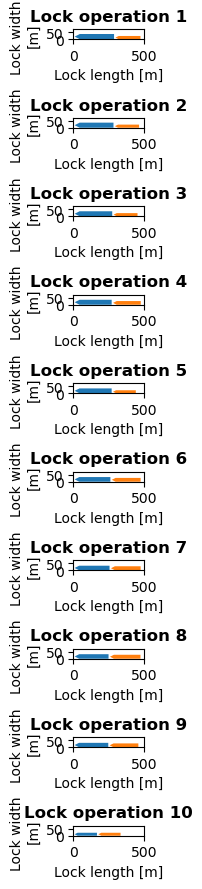

    lock_operation  x_left_loc  y_top_loc     B      L
2                2           0       10.0  35.0  266.0
3                3           0       10.0  35.0  262.0
4                4           0       10.0  34.0  262.0
5                5           0       10.0  33.0  253.0
6                6           0       10.0  32.0  247.0
7                7           0       10.0  32.0  240.0
8                8           0       10.0  31.0  238.0
9                7           0      260.0  28.0  216.0
10               6           0      267.0  28.0  210.0
11               5           0      273.0  27.0  204.0
12               8           0      258.0  27.0  203.0
13               3           0      282.0  26.0  196.0
16               2           0      286.0  22.0  169.0
17               4           0      282.0  21.0  161.0
18               9           0       10.0  21.0  158.0
19               9           0      178.0  21.0  157.0
return code:4
status:OPTIMAL
    lock_operation  x_left_loc  y_to

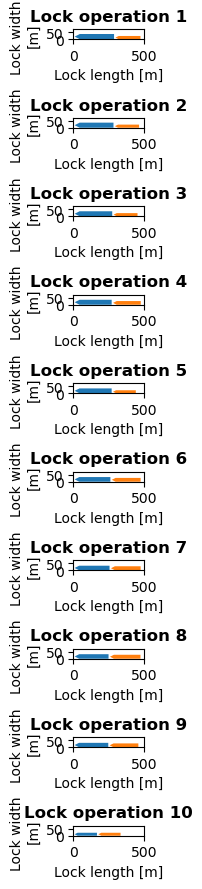

    lock_operation  x_left_loc  y_top_loc     B      L
3                3           0       10.0  35.0  262.0
4                4           0       10.0  34.0  262.0
5                5           0       10.0  33.0  253.0
6                6           0       10.0  32.0  247.0
7                7           0       10.0  32.0  240.0
8                8           0       10.0  31.0  238.0
9                7           0      260.0  28.0  216.0
10               6           0      267.0  28.0  210.0
11               5           0      273.0  27.0  204.0
12               8           0      258.0  27.0  203.0
13               3           0      282.0  26.0  196.0
17               4           0      282.0  21.0  161.0
18               9           0       10.0  21.0  158.0
19               9           0      178.0  21.0  157.0
return code:4
status:OPTIMAL
    lock_operation  x_left_loc  y_top_loc     B      L
0                1           0       10.0  35.0  262.0
1                0           0      

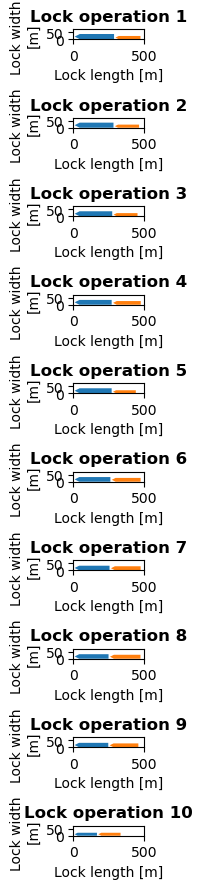

    lock_operation  x_left_loc  y_top_loc     B      L
3                4           0       10.0  35.0  262.0
5                5           0       10.0  33.0  253.0
6                6           0       10.0  32.0  247.0
7                7           0       10.0  32.0  240.0
8                8           0       10.0  31.0  238.0
9                7           0      260.0  28.0  216.0
10               6           0      267.0  28.0  210.0
11               5           0      273.0  27.0  204.0
12               8           0      258.0  27.0  203.0
17               4           0      282.0  21.0  161.0
18               9           0       10.0  21.0  158.0
19               9           0      178.0  21.0  157.0
return code:4
status:OPTIMAL
    lock_operation  x_left_loc  y_top_loc     B      L
0                0           0       10.0  35.0  262.0
1                1           0       10.0  33.0  253.0
2                2           0       10.0  32.0  247.0
3                3           0      

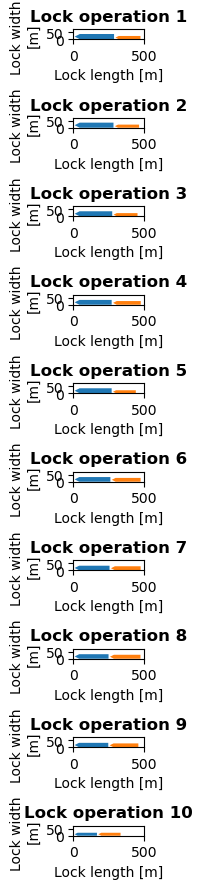

    lock_operation  x_left_loc  y_top_loc     B      L
5                5           0       10.0  33.0  253.0
6                6           0       10.0  32.0  247.0
7                7           0       10.0  32.0  240.0
8                8           0       10.0  31.0  238.0
9                7           0      260.0  28.0  216.0
10               6           0      267.0  28.0  210.0
11               5           0      273.0  27.0  204.0
12               8           0      258.0  27.0  203.0
18               9           0       10.0  21.0  158.0
19               9           0      178.0  21.0  157.0
return code:4
status:OPTIMAL
   lock_operation  x_left_loc  y_top_loc     B      L
0               0           0       10.0  33.0  253.0
1               1           0       10.0  32.0  247.0
2               2           0       10.0  32.0  240.0
3               3           0       10.0  31.0  238.0
4               2           0      260.0  28.0  216.0
5               1           0      267.0  

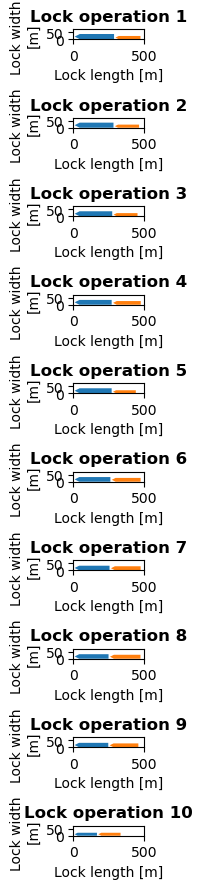

    lock_operation  x_left_loc  y_top_loc     B      L
6                6           0       10.0  32.0  247.0
7                7           0       10.0  32.0  240.0
8                8           0       10.0  31.0  238.0
9                7           0      260.0  28.0  216.0
10               6           0      267.0  28.0  210.0
12               8           0      258.0  27.0  203.0
18               9           0       10.0  21.0  158.0
19               9           0      178.0  21.0  157.0
return code:4
status:OPTIMAL
   lock_operation  x_left_loc  y_top_loc     B      L
0               0           0       10.0  32.0  247.0
1               1           0       10.0  32.0  240.0
2               2           0       10.0  31.0  238.0
3               1           0      260.0  28.0  216.0
4               0           0      267.0  28.0  210.0
5               2           0      258.0  27.0  203.0
6               3           0       10.0  21.0  158.0
7               3           0      178.0  21

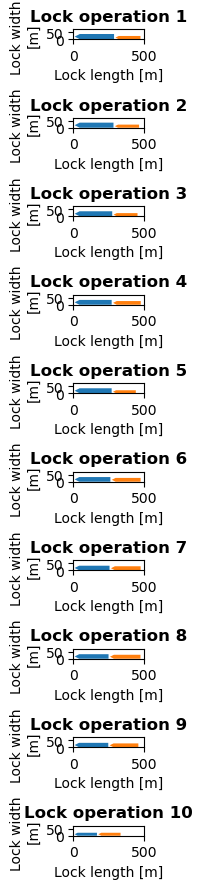

    lock_operation  x_left_loc  y_top_loc     B      L
7                7           0       10.0  32.0  240.0
8                8           0       10.0  31.0  238.0
9                7           0      260.0  28.0  216.0
12               8           0      258.0  27.0  203.0
18               9           0       10.0  21.0  158.0
19               9           0      178.0  21.0  157.0
return code:4
status:OPTIMAL
   lock_operation  x_left_loc  y_top_loc     B      L
0               0           0       10.0  32.0  240.0
1               1           0       10.0  31.0  238.0
2               0           0      260.0  28.0  216.0
3               1           0      258.0  27.0  203.0
4               2           0       10.0  21.0  158.0
5               2           0      178.0  21.0  157.0
    lock_operation  x_left_loc  y_top_loc     B      L
0                0           0       10.0  37.0  279.0
1                1           0       10.0  36.0  275.0
2                2           0       10.0  

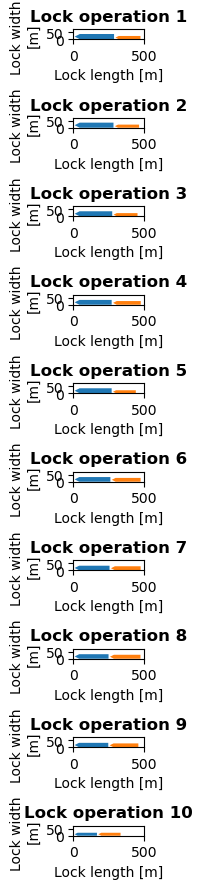

    lock_operation  x_left_loc  y_top_loc     B      L
8                8           0       10.0  31.0  238.0
12               8           0      258.0  27.0  203.0
18               9           0       10.0  21.0  158.0
19               9           0      178.0  21.0  157.0
return code:4
status:OPTIMAL
   lock_operation  x_left_loc  y_top_loc     B      L
0               0           0       10.0  31.0  238.0
1               0           0      258.0  27.0  203.0
2               1           0       10.0  21.0  158.0
3               1           0      178.0  21.0  157.0
    lock_operation  x_left_loc  y_top_loc     B      L
0                0           0       10.0  37.0  279.0
1                1           0       10.0  36.0  275.0
2                2           0       10.0  35.0  266.0
3                4           0       10.0  35.0  262.0
4                3           0       10.0  34.0  262.0
5                5           0       10.0  33.0  253.0
6                6           0       10.0

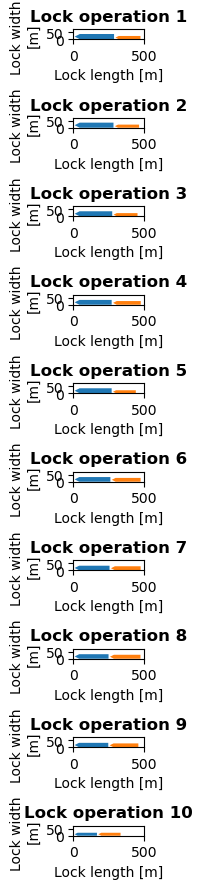

    lock_operation  x_left_loc  y_top_loc     B      L
18               9           0       10.0  21.0  158.0
19               9           0      178.0  21.0  157.0
return code:4
status:OPTIMAL
   lock_operation  x_left_loc  y_top_loc     B      L
0               0           0      164.0  21.0  158.0
1               1           0       10.0  21.0  157.0
    lock_operation  x_left_loc  y_top_loc     B      L
0                0           0       10.0  37.0  279.0
1                1           0       10.0  36.0  275.0
2                2           0       10.0  35.0  266.0
3                4           0       10.0  35.0  262.0
4                3           0       10.0  34.0  262.0
5                5           0       10.0  33.0  253.0
6                6           0       10.0  32.0  247.0
7                7           0       10.0  32.0  240.0
8                8           0       10.0  31.0  238.0
9                7           0      260.0  28.0  216.0
10               6           0      267

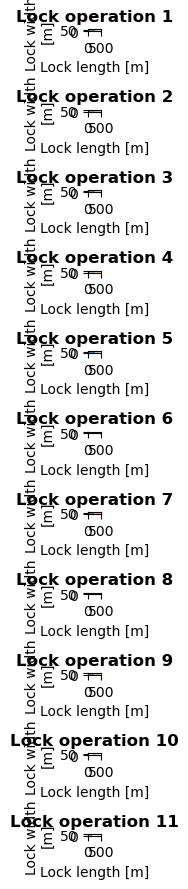

19 157.0 heyho
y_top_loc: 164.0
Empty DataFrame
Columns: [lock_operation, x_left_loc, y_top_loc, B, L]
Index: []


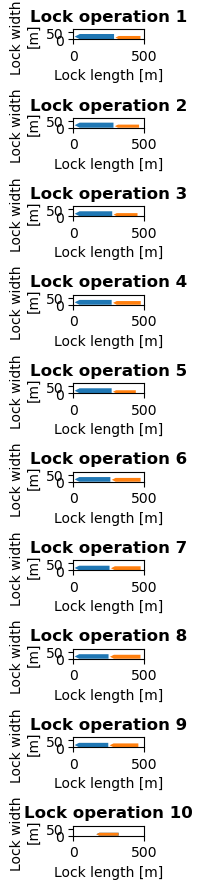

In [10]:
lock_dimensions = (500,70)
max_safety_length = 10
max_safety_width = 50

# First run
vessel_planning = further_vessel_planning = lock_planning_model(vessel_queue = vessel_queue, lock_dimensions = lock_dimensions, max_safety_length = max_safety_length)
print(vessel_planning)

# Optimization 
lock_operations = list(dict.fromkeys(vessel_planning.lock_operation.values))
for lock_operation in lock_operations:
    lock_operation_df = further_vessel_planning[further_vessel_planning.lock_operation == lock_operation]
    for _,placed_vessel in lock_operation_df.iterrows():
        if placed_vessel.x_left_loc == 0:
            next_vessels = vessel_planning[vessel_planning.lock_operation > lock_operation]
            y_top_loc = placed_vessel.y_top_loc
            virtual_lock_length = placed_vessel.L
            virtual_lock_width = lock_dimensions[1] - placed_vessel.B - max_safety_width
            for loc,next_vessel in next_vessels.iterrows():
                if next_vessel.L <= virtual_lock_length and next_vessel.B <= virtual_lock_width:
                    print(loc,next_vessel.L)
                    virtual_lock_length -= next_vessel.L
                    vessel_planning.loc[loc,'lock_operation'] = lock_operation
                    vessel_planning.loc[loc,'x_left_loc'] = lock_dimensions[1]-next_vessel.B
                    vessel_planning.loc[loc,'y_top_loc'] = y_top_loc
                    print('y_top_loc:',y_top_loc)
                    y_top_loc -= (next_vessel.L+max_safety_length)

    remaining_virtual_lock_length = lock_dimensions[0]-(placed_vessel.y_top_loc+placed_vessel.L+2*max_safety_length)
    remaining_virtual_lock_width = lock_dimensions[1]
    next_vessels = vessel_planning[vessel_planning.lock_operation > lock_operation]
    x_left_loc = 0
    for loc,next_vessel in next_vessels.iterrows():
        if next_vessel.L <= remaining_virtual_lock_length and next_vessel.B <= remaining_virtual_lock_width:
            print(loc,next_vessel.L,'heyho')
            remaining_virtual_lock_length -= next_vessel.L
            remaining_virtual_lock_width -= next_vessel.B
            vessel_planning.loc[loc,'lock_operation'] = lock_operation
            vessel_planning.loc[loc,'x_left_loc'] = x_left_loc
            print('y_top_loc:',y_top_loc)
            vessel_planning.loc[loc,'y_top_loc'] = y_top_loc
            x_left_loc -= (next_vessel.B+max_safety_width)
            y_top_loc -= (next_vessel.L+max_safety_length)

    vessel_queue_optimized = vessel_planning[vessel_planning.lock_operation > lock_operation]
    print(vessel_queue_optimized)
    if not vessel_queue_optimized.empty:
        further_vessel_planning = lock_planning_model(vessel_queue = vessel_queue_optimized, lock_dimensions = lock_dimensions, max_safety_length = max_safety_length)
        print(further_vessel_planning)
        further_vessel_planning.loc[:,'lock_operation'] += lock_operation + 1
        further_vessel_planning.index = vessel_queue_optimized.index
        for loc,next_vessel in further_vessel_planning.iterrows():
            if not vessel_planning.loc[loc,:].equals(next_vessel):
                vessel_planning.loc[loc,:] = next_vessel 
        print(vessel_planning)

    number_of_lock_operations = int(vessel_planning['lock_operation'].max()+1)
    fig,axes = plt.subplots(number_of_lock_operations,1,figsize=(16,9))
    for lock_operation_nr in range(number_of_lock_operations):
        if number_of_lock_operations > 1:
            ax = axes[lock_operation_nr]
        else:
            ax = axes
        ax.set_xlim(0,lock_dimensions[0])
        ax.set_ylim(0,lock_dimensions[1])
        for _,v in vessel_planning[vessel_planning.lock_operation == lock_operation_nr].iterrows():
            x_loc = v['y_top_loc']+v['L']/2
            y_loc = v['x_left_loc']+v['B']/2
            x_coords, y_coords = vessel_shape(v['L'],v['B'],x_loc,y_loc,direction=-90)
            ax.fill(x_coords, y_coords)
        ax.set_title(f'Lock operation {lock_operation_nr+1}',weight='bold')
        ax.set_xlabel('Lock length [m]')
        ax.set_ylabel('Lock width \n[m]')
        ax.set_aspect('equal')
    plt.tight_layout()
    vessel_planning
    plt.show()

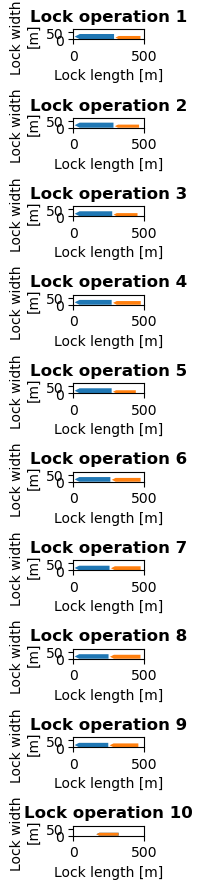

In [11]:
number_of_lock_operations = int(vessel_planning['lock_operation'].max()+1)
fig,axes = plt.subplots(number_of_lock_operations,1,figsize=(16,9))
for lock_operation_nr in range(number_of_lock_operations):
    if number_of_lock_operations > 1:
        ax = axes[lock_operation_nr]
    else:
        ax = axes
    ax.set_xlim(0,lock_dimensions[0])
    ax.set_ylim(0,lock_dimensions[1])
    for _,v in vessel_planning[vessel_planning.lock_operation == lock_operation_nr].iterrows():
        x_loc = v['y_top_loc']+v['L']/2
        y_loc = v['x_left_loc']+v['B']/2
        x_coords, y_coords = vessel_shape(v['L'],v['B'],x_loc,y_loc,direction=-90)
        ax.fill(x_coords, y_coords)
    ax.set_title(f'Lock operation {lock_operation_nr+1}',weight='bold')
    ax.set_xlabel('Lock length [m]')
    ax.set_ylabel('Lock width \n[m]')
    ax.set_aspect('equal')
plt.tight_layout()
vessel_planning
plt.show()

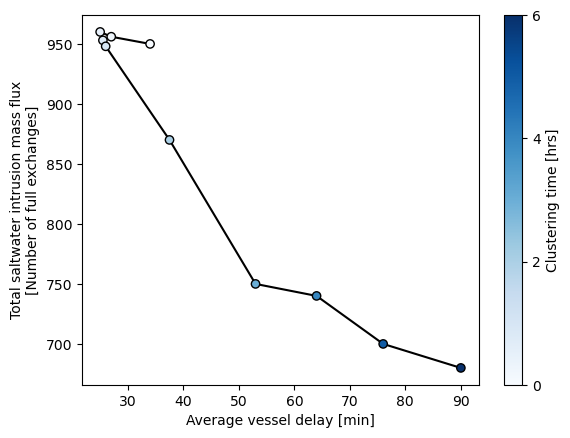

In [26]:
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm

cmap = cm.Blues
norm = Normalize(vmin=0, vmax=6)

x = [19+15,12+15,10+15,10.5+15,11+15,22.5+15,38+15,49+15,61+15,75+15] #Vessel delay
y = [950,956,960,953,948,870,750,740,700,680] #Saltwater intrusion mass flux
c = [0,0.25,0.5,0.75,1,2,3,4,5,6] #Clustering time

fig,ax = plt.subplots()
ax.set_xlabel('Average vessel delay [min]')
ax.set_ylabel('Total saltwater intrusion mass flux\n[Number of full exchanges]')
ax.plot(x,y,color='k')
im = ax.scatter(x,y,c=c, edgecolor='k', cmap=cmap, norm=norm,zorder=2)
cbar = fig.colorbar(im)
cbar.set_label('Clustering time [hrs]')
cbar_ticks = np.arange(c[0],c[-1]+2,2)
cbar.ax.set_yticks(cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticks);

In [20]:
1000*950000/(545*70*17.75*10)

140.29128901851476